# Week 3 Assignment

## Part 1
Read in the Toronto table from Wikipedia and drop unassigned boroughs

In [163]:
import pandas as pd
try:
    import geocoder
except:
    !pip install geocoder
    import geocoder
try:
    import folium
except:
    !pip install folium
    #!conda install -c conda-forge folium=0.5.0 --yes
    import folium

In [235]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=946126446'

# df = pd.read_html(url)[0]
df = pd.DataFrame(pd.read_html(url)[0].values,columns = ['PostalCode','Borough','Neighborhood'])
df = df[df['Borough']!='Not assigned']
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
# df['Neighborhood'].replace('Not assigned',df['Borough'],inplace=True)
df.sample(10)

,PostalCode,Borough,Neighborhood
79,M6L,North York,"Downsview, North Park, Upwood Park"
3,M1G,Scarborough,Woburn
48,M4T,Central Toronto,"Moore Park, Summerhill East"
47,M4S,Central Toronto,Davisville
21,M2M,North York,"Newtonbrook, Willowdale"
54,M5B,Downtown Toronto,"Ryerson, Garden District"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
27,M3C,North York,"Flemingdon Park, Don Mills South"
90,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
4,M1H,Scarborough,Cedarbrae


In [165]:
df.shape

(103, 3)

## Part 2

In [166]:
for postal_code in df['PostalCode']:
    break
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]

In [167]:
coords = pd.read_csv('https://cocl.us/Geospatial_data')
coords.columns = ['PostalCode','Latitude','Longitude']
toronto_data = pd.merge(df,coords,on='PostalCode').sort_values('Latitude').sort_index()

In [168]:
toronto_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


## Part 3

In [169]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium
import requests
import numpy as np

In [170]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [171]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for i, pc in toronto_data.iterrows():
    label = '{}, {}'.format(pc['Neighborhood'], pc['PostalCode'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [pc['Latitude'], pc['Longitude']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

In [172]:
CLIENT_ID = 'KBISHQXB1DEVMGJQJYYTQOEKQY4T0JWBOAWXA5BFQZLMKQRR'
CLIENT_SECRET = 'GQMHD2IR0HNOI4UAO2NMIU231EESAWCXOSA2OE2CI5LTPQFR'
VERSION = '20180605'
LIMIT = 100

In [173]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [174]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'],
                                   radius=1500
                                  )

In [208]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [209]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [210]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

<AxesSubplot:>

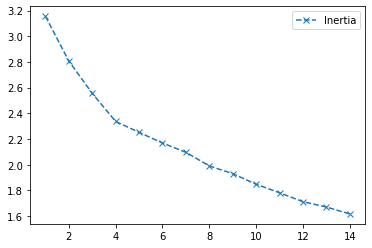

In [211]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
cluster_inertias = []

for kclusters in range(1,15):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(toronto_grouped_clustering)
    cluster_inertias.append(kmeans.inertia_)

pd.DataFrame(cluster_inertias,index=range(1,15),columns=['Inertia']).plot(style='x--')

## Optimal number of clusters
Based on the above chart, the optimal number of clusters is 4.

In [212]:
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(toronto_grouped_clustering)
toronto_merged['Cluster Labels'].value_counts()

2    59
1    41
0     2
3     1
Name: Cluster Labels, dtype: int64

In [213]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.loc[toronto_merged['Cluster Labels'].isna(),'Cluster Labels'] = toronto_merged['Cluster Labels'].max() + 1
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Zoo Exhibit,Coffee Shop,Fast Food Restaurant,Pizza Place,Restaurant,Supermarket,Filipino Restaurant,Gas Station,Caribbean Restaurant,Liquor Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Park,Italian Restaurant,Hotel,Breakfast Spot,Grocery Store,Gym,Burger Joint,Gym / Fitness Center,New American Restaurant,Office
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Pizza Place,Bank,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Greek Restaurant,Laundromat,Sandwich Place,Gym / Fitness Center,Electronics Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Pharmacy,Fast Food Restaurant,Pizza Place,Sandwich Place,Bakery,Burger Joint,Bus Line,Supermarket,Café
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Restaurant,Clothing Store,Coffee Shop,Gas Station,Bakery,Indian Restaurant,Sandwich Place,Pharmacy,Bank,Burger Joint


In [231]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)*2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [219]:
cols = toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))].drop('Cluster Labels')

## Cluster 1

In [220]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, cols]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,Park,Italian Restaurant,Hotel,Breakfast Spot,Grocery Store,Gym,Burger Joint,Gym / Fitness Center,New American Restaurant,Office
8,Scarborough,Park,Harbor / Marina,Pizza Place,Coffee Shop,Sandwich Place,Grocery Store,Fast Food Restaurant,Pub,Beach,Ice Cream Shop
19,North York,Gas Station,Trail,Park,Bank,Japanese Restaurant,Grocery Store,Café,Chinese Restaurant,Restaurant,Athletics & Sports
31,North York,Park,Bank,Plaza,Pizza Place,Tea Room,Zoo Exhibit,Music Venue,Non-Profit,Nightclub,New American Restaurant
88,Etobicoke,Park,Indian Restaurant,Café,Grocery Store,Bakery,Beer Store,Liquor Store,Bar,Thai Restaurant,Elementary School
93,Etobicoke,Pharmacy,Park,Bank,Golf Course,Supermarket,Shopping Mall,Liquor Store,Grocery Store,Café,Bus Line
94,Etobicoke,Park,Gym / Fitness Center,Farmers Market,Hotel,Bank,Convenience Store,Fish & Chips Shop,Gym,Pizza Place,Skating Rink
96,North York,Park,Asian Restaurant,Sports Bar,Café,Food Court,Electronics Store,ATM,Bank,Bakery,Shopping Mall


## Cluster 2

In [221]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, cols]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,Zoo Exhibit,Coffee Shop,Fast Food Restaurant,Pizza Place,Restaurant,Supermarket,Filipino Restaurant,Gas Station,Caribbean Restaurant,Liquor Store
2,Scarborough,Pizza Place,Bank,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Greek Restaurant,Laundromat,Sandwich Place,Gym / Fitness Center,Electronics Store
3,Scarborough,Coffee Shop,Pharmacy,Fast Food Restaurant,Pizza Place,Sandwich Place,Bakery,Burger Joint,Bus Line,Supermarket,Café
4,Scarborough,Restaurant,Clothing Store,Coffee Shop,Gas Station,Bakery,Indian Restaurant,Sandwich Place,Pharmacy,Bank,Burger Joint
5,Scarborough,Sandwich Place,Pharmacy,Ice Cream Shop,Pizza Place,Coffee Shop,Bank,Chinese Restaurant,Fish & Chips Shop,Beer Store,Fast Food Restaurant
6,Scarborough,Pharmacy,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Sporting Goods Shop,Grocery Store,Department Store,Health Food Store
7,Scarborough,Coffee Shop,Pizza Place,Hardware Store,Sandwich Place,Park,Convenience Store,Greek Restaurant,Bar,Grocery Store,Bank
10,Scarborough,Fast Food Restaurant,Coffee Shop,Restaurant,Pizza Place,Chinese Restaurant,Bank,Intersection,Grocery Store,Park,Pet Store
11,Scarborough,Middle Eastern Restaurant,Pizza Place,Indian Restaurant,Grocery Store,Restaurant,Coffee Shop,Sandwich Place,Burger Joint,Indian Chinese Restaurant,Greek Restaurant
12,Scarborough,Chinese Restaurant,Shopping Mall,Coffee Shop,Cantonese Restaurant,Caribbean Restaurant,Park,Hong Kong Restaurant,Bakery,Japanese Restaurant,Gym / Fitness Center


## Cluster 3

In [223]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, cols]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Scarborough,Farm,National Park,Donut Shop,Moroccan Restaurant,Movie Theater,Optical Shop,Office,Nudist Beach,Noodle House,Non-Profit


## Cluster 4

In [226]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, cols]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Scarborough,Convenience Store,Golf Course,Ice Cream Shop,General Entertainment,College Stadium,Filipino Restaurant,Café,Gym,Park,Restaurant
30,North York,Gym / Fitness Center,Athletics & Sports,Bus Station,Racetrack,Coffee Shop,Turkish Restaurant,Arts & Crafts Store,Basketball Court,Gym,Climbing Gym
40,East York,Greek Restaurant,Coffee Shop,Café,Pizza Place,Bakery,Ethiopian Restaurant,Park,Ice Cream Shop,Italian Restaurant,Cosmetics Shop
41,East Toronto,Greek Restaurant,Café,Park,Coffee Shop,Pub,Bakery,Pizza Place,Ice Cream Shop,Trail,Italian Restaurant
42,East Toronto,Coffee Shop,Park,Bakery,Brewery,Indian Restaurant,Restaurant,Beach,Café,BBQ Joint,Grocery Store
43,East Toronto,Coffee Shop,Bakery,Diner,Café,Pizza Place,Park,Vietnamese Restaurant,Grocery Store,Bar,Pub
44,Central Toronto,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bakery,Fast Food Restaurant,Food Court,Asian Restaurant,Bank,Sandwich Place,Café
45,Central Toronto,Italian Restaurant,Coffee Shop,Sushi Restaurant,Park,Restaurant,Café,Pizza Place,Dessert Shop,Bakery,Indian Restaurant
46,Central Toronto,Coffee Shop,Italian Restaurant,Café,Japanese Restaurant,Sushi Restaurant,Bakery,Fast Food Restaurant,Restaurant,Sporting Goods Shop,Gym
47,Central Toronto,Italian Restaurant,Coffee Shop,Pizza Place,Bakery,Café,Park,Restaurant,Indian Restaurant,Japanese Restaurant,Sushi Restaurant
